In [1]:
import pandas as pd
import openai
import time
import re
from scipy import stats
from sklearn.metrics import mean_absolute_error
import pickle
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM


api_key = open('openai.key', 'r').read()
openai.api_key = api_key

# Prompt Preperation and Helper Methods

Description from paper: 
- The participants in this study were first asked to stand up and focus on different aspects of their bodily experience of standing in the same way as did participants in Experiment 1.
- Following this, we introduced the five image schemas of BALANCE, VERTICALITY, CENTER-PERIPHERY, RESISTANCE, and LINKAGE as was done in Experiment 1

In [94]:
DEFINITIONS = {
    "VERTICALITY": "Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.",
    "BALANCE": "Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.",
    "CENTER-PERIPHERY": "Consider the notion of CENTER-PERIPHERY. Center-periphery refers to the experience of some objects or events as central while surrounding objects and events are peripheral or to the outside.",
    "LINKAGE": "Consider the notion of LINKAGE. Linkage refers to the perception of a connection between objects or events.",
    "RESISTANCE": "Consider the notion of RESISTANCE. Resistance refers to the experience of your body opposing some external force."
}

In [3]:
exp_3_df = pd.read_csv('../../data/Gibbs_Exp3.csv', sep=';')
# drop nan rows
exp_3_df = exp_3_df.dropna()
exp_4_df = pd.read_csv('../../data/Gibbs_Exp4.csv', sep=';')
stimuli_exp3 = exp_3_df['Stimulus'].values
stimuli_exp4 = exp_4_df['Stimulus'].values
print(len(stimuli_exp3))
print(len(stimuli_exp4))

32
32


In [4]:
# create prompts
prompts_exp3 = {"VERTICALITY":[], "BALANCE":[], "CENTER-PERIPHERY":[], "LINKAGE":[], "RESISTANCE":[]}
prompts_exp4 = {"VERTICALITY":[], "BALANCE":[], "CENTER-PERIPHERY":[], "LINKAGE":[], "RESISTANCE":[]}


for i in range(len(stimuli_exp3)):
    prompt_ending =  "How strongly is the phrase ''" + stimuli_exp3[i] + "'' related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?"
    prompts_exp3["VERTICALITY"].append(DEFINITIONS["VERTICALITY"] + "\n" + prompt_ending)
    prompts_exp3["BALANCE"].append(DEFINITIONS["BALANCE"] + "\n" + prompt_ending)
    prompts_exp3["CENTER-PERIPHERY"].append(DEFINITIONS["CENTER-PERIPHERY"] + "\n" + prompt_ending)
    prompts_exp3["LINKAGE"].append(DEFINITIONS["LINKAGE"] + "\n" + prompt_ending)
    prompts_exp3["RESISTANCE"].append(DEFINITIONS["RESISTANCE"] + "\n" + prompt_ending)

for i in range(len(stimuli_exp4)):
    prompt_ending =  "How strongly is the phrase ''" + stimuli_exp4[i] + "'' related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?"
    prompts_exp4["VERTICALITY"].append(DEFINITIONS["VERTICALITY"] + "\n" + prompt_ending)
    prompts_exp4["BALANCE"].append(DEFINITIONS["BALANCE"] + "\n" + prompt_ending)
    prompts_exp4["CENTER-PERIPHERY"].append(DEFINITIONS["CENTER-PERIPHERY"] + "\n" + prompt_ending)
    prompts_exp4["LINKAGE"].append(DEFINITIONS["LINKAGE"] + "\n" + prompt_ending)
    prompts_exp4["RESISTANCE"].append(DEFINITIONS["RESISTANCE"] + "\n" + prompt_ending)

In [148]:
# variants with which GPT can be prompted to generate the questionnaire answers
def gpt_complete(prompt, model):
    temperature = 0
    # the create functiosn differ for chat and non-chat models
    if "turbo" in model:
        system_message="You are a participant in a research experiment."
        return openai.ChatCompletion.create(
            model=model,
            messages=[ {"role": "system", "content": system_message},
                {"role": "user", "content": prompt}],
            temperature=temperature
            )
    else:
        return openai.Completion.create(
            model=model,
            prompt=prompt,
            temperature=temperature
        ) 

def gpt_complete_proba(prompt, model):
    # get the probability distribution over the next token for the tokens 1, 2, 3, 4, 5, 6, 7
    temperature = 0
    results = []
    debug = []
    for i in range(1, 8):
        next_prompt = prompt + "\n\n"+ str(i)
        print(next_prompt)
        if "turbo" in model:
            system_message="You are a participant in a research experiment."
            result = openai.ChatCompletion.create(                                          # TODO: add logprobs once available in the API! 
                model=model,
                messages=[ {"role": "system", "content": system_message},
                    {"role": "user", "content": next_prompt}],
                temperature=temperature,
                max_tokens=1,
            )

        else:
            result = openai.Completion.create(
                model=model,
                prompt=next_prompt,
                max_tokens=1,
                temperature=temperature,
                logprobs=1,
                echo=True
            )
        debug.append(result)
        #print(result)
        # the index of i in the list of tokens
        index = result["choices"][0]["logprobs"]["tokens"].index(str(i))
        print(index)
        print(result["choices"][0]["logprobs"]["token_logprobs"][index])
        print(np.exp(result["choices"][0]["logprobs"]["token_logprobs"][index]))
        print(result["choices"][0]["logprobs"]["tokens"][index])
        print()
        log_prob_result=result["choices"][0]["logprobs"]["token_logprobs"][index]
        prob_result = np.exp(log_prob_result)
        results.append(prob_result)
        # wait 20 seconds to avoid exceeding the API rate limit
        time.sleep(21)
    average_completion = 0
    for i in range(1, 8):
        average_completion += i * results[i-1]
    average_completion = average_completion / sum(results)      # TODO: verify this is the right operation

    return results, average_completion, debug

 
def gpt_complete_reasoning(prompt, model):
    prompt += "Reason step by step: \n"
    return gpt_complete(prompt, model)

def gpt_with_nearly_full_instructions(model, image_schema, stimuli):
    prompt = DEFINITIONS[image_schema]
    prompt += "\n\n" + "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to this notion: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    return gpt_complete(prompt, model)

def gpt_with_full_instructions(model, stimuli):
    prompt = ""
    for d in DEFINITIONS.values():
        prompt += d + "\n\n"
    prompt += "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to these 5 notions. You will need to provide 5 scores per stimulus: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    prompt += "\n\n" +"Give each stimulus 5 ratings (VERTICALITY, BALANCE, CENTER-PERIPHERY, LINKAGE, RESISTANCE): "
    return gpt_complete(prompt, model)
    

def gpt_simulate_human(prompt, model, name, gender):           # TE paradigm 
    prompt = name + " was asked to..." + name +" responded with the number: " + prompt
    pass

In [138]:
def hf_complete(prompt, model):
    pass

def hf_complete_proba(prompt, model):
    pass

In [6]:
# example prompt
prompts_exp3["VERTICALITY"][0]

"Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase ''stand at attention'' related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?"

In [58]:
# test with log probs 
model = "text-davinci-003"

probas,r,d = gpt_complete_proba(prompt=prompts_exp3["VERTICALITY"][1], model=model)
print(probas)
print(r)


[0.4693367739968185, 0.6304976189698971, 0.0021300609172966016, 0.0004053786456902955, 0.00030428463356096594, 2.8846006426974795e-05, 4.566600513491415e-06]
1.5779979076082327


# Analysis Helpers

In [132]:
def make_bar_plots(model_result_dict_3, model_result_dict_4, title):
    # Visualize results as bar charts with 2 bars per key (one for each experiment) and each bar being the correlation coefficient
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel("Image Schema")
    plt.ylabel("Spearman Correlation Coefficient")
    for key in DEFINITIONS:
        # the bars of the two experiments are next to each other
        plt.bar(key, stats.spearmanr(model_result_dict_3[key], exp_3_df[key])[0], width=0.4, color='orange')
        # move the bar to the right
        plt.bar(key, stats.spearmanr(model_result_dict_4[key], exp_4_df[key])[0], width=0.4, align='edge', color='blue')
    plt.legend(["Experiment 3", "Experiment 4"])
    plt.show()

def make_scatter_plots(model_result_dict_3, model_result_dict_4, title):
    # plot side by side, 5 plots
    fig, axs = plt.subplots(2, 5, figsize=(20, 6))
    fig.suptitle(title)
    for i, key in enumerate(DEFINITIONS):
        axs[0, i].scatter(model_result_dict_3[key], exp_3_df[key], color='orange')
        axs[0, i].set_title(key)
        if i==0: axs[0, i].set_ylabel("Human Rating (Exp 3)")
        axs[1, i].scatter(model_result_dict_4[key], exp_4_df[key], color='blue')
        axs[1, i].set_xlabel("GPT Rating")
        if i ==0: axs[1, i].set_ylabel("Human Rating (Exp 4)")
        # set x and y limits to 0 to 7.2
        axs[0, i].set_xlim(0.7, 7.2)
        axs[0, i].set_ylim(0.7, 7.2)
        axs[1, i].set_xlim(0.7, 7.2)
        axs[1, i].set_ylim(0.7, 7.2)
        # set x and y ticks to 0, 1, 2, ..., 7
        axs[0, i].set_xticks(np.arange(1, 8, 1))
        axs[0, i].set_yticks(np.arange(1, 8, 1))
        axs[1, i].set_xticks(np.arange(1, 8, 1))
        axs[1, i].set_yticks(np.arange(1, 8, 1))
        # add correlation coefficient to each plot
        axs[0, i].text(0.05, 0.95, "r = " + str(round(stats.spearmanr(model_result_dict_3[key], exp_3_df[key])[0], 2)), transform=axs[0, i].transAxes, fontsize=12, verticalalignment='top')
        axs[1, i].text(0.05, 0.95, "r = " + str(round(stats.spearmanr(model_result_dict_4[key], exp_4_df[key])[0], 2)), transform=axs[1, i].transAxes, fontsize=12, verticalalignment='top')

def print_correlations(model_result_dict_3, model_result_dict_4):
    for key in DEFINITIONS:
        print(key)
        print("Experiment 3: " + str(stats.spearmanr(model_result_dict_3[key], exp_3_df[key])))
        print("Experiment 4: " + str(stats.spearmanr(model_result_dict_4[key], exp_4_df[key])))
        print("")

# Huggingface Model Experiments

In [9]:
import sys
sys.path.append('../experiment_01')
from sidemethods import logprobs_from_prompt, proc, proc_lower, prob_of_ending

In [3]:
hf_tokenizer = AutoTokenizer.from_pretrained("openlm-research/open_llama_3b")
hf_model = AutoModelForCausalLM.from_pretrained("openlm-research/open_llama_3b")

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [6]:
# get completion from hf_model
# Step 1: Tokenize the prompt
input_ids = hf_tokenizer.encode("test", return_tensors="pt")

# Step 2: Generate the model input
max_length = 9999
output = hf_model.generate(input_ids, max_length=max_length, num_return_sequences=1)

# Step 3: Decode the generated output to get the answer
generated_answer = hf_tokenizer.decode(output[0], skip_special_tokens=True)

# Step 4: Print the answer
print(generated_answer)

KeyboardInterrupt: 

In [ ]:
start = "nazis are known to be on the political "
answers = {0:"left", 1:"right"}

res_ends = []
for j, end in answers.items():
    input_prompt = proc(start) + ' ' + proc(end)
    print(input_prompt)
    logprobs = logprobs_from_prompt(input_prompt, hf_tokenizer, hf_model)
    res = {"tokens": [x for x,y in logprobs],"token_logprobs": [y for x,y in logprobs]}
    res_ends.append(res)
    print(end)
    print(res)
    print()
print(res_ends)

# Full Questionaire Experiments (all Image Schemas)

In [149]:
model="gpt-3.5-turbo-0613"

# get completions all at once
gpt_c3=gpt_with_full_instructions(model=model, stimuli=stimuli_exp3) 
time.sleep(20)
gpt_c4=gpt_with_full_instructions(model=model, stimuli=stimuli_exp4)



 VERTICALITY

 BALANCE

 CENTER-PERIPHERY

 LINKAGE

 RESISTANCE


In [158]:
c3=gpt_c3["choices"][0]["message"]["content"]
c4=gpt_c4["choices"][0]["message"]["content"]
full_history_results_exp3={}
full_history_results_exp4={}
for key in DEFINITIONS:                    
    full_history_results_exp3[key]=[]
    full_history_results_exp4[key]=[]
# c3 looks like this:  # "1: stand at attention\nVerticality: 7\nBalance: 7\nCenter-periphery: 1\nLinkage: 1\nResistance: 1\n\n2: ..."
c3_by_stimulus=c3.split("\n\n")
c4_by_stimulus=c4.split("\n\n")
for rs in c3_by_stimulus:
    rs = rs.split("\n")
    for r in rs:
        # get number after ":"
        r=r.split(":")
        number=r[1].strip()
        # check if number is int
        try:
            number=int(number)
        except:
            continue
        if r[0].strip()=="Verticality":
            full_history_results_exp3["VERTICALITY"].append(number)
        elif r[0].strip()=="Balance":
            full_history_results_exp3["BALANCE"].append(number)
        elif r[0].strip()=="Center-periphery":
            full_history_results_exp3["CENTER-PERIPHERY"].append(number)
        elif r[0].strip()=="Linkage":
            full_history_results_exp3["LINKAGE"].append(number)
        elif r[0].strip()=="Resistance":
            full_history_results_exp3["RESISTANCE"].append(number)
for rs in c4_by_stimulus:
    rs = rs.split("\n")
    for r in rs:
        # get number after ":"
        r=r.split(":")
        number=r[1].strip()
        # check if number is int
        try:
            number=int(number)
        except:
            continue
        if r[0].strip()=="Verticality":
            full_history_results_exp4["VERTICALITY"].append(number)
        elif r[0].strip()=="Balance":
            full_history_results_exp4["BALANCE"].append(number)
        elif r[0].strip()=="Center-periphery":
            full_history_results_exp4["CENTER-PERIPHERY"].append(number)
        elif r[0].strip()=="Linkage":
            full_history_results_exp4["LINKAGE"].append(number)
        elif r[0].strip()=="Resistance":
            full_history_results_exp4["RESISTANCE"].append(number)

In [ ]:
# full_history_results_expX to pkl
with open('full_history_results_exp4.pkl', 'wb') as f:
    pickle.dump(full_history_results_exp4, f)

with open('full_history_results_exp3.pkl', 'wb') as f:
    pickle.dump(full_history_results_exp3, f)   

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


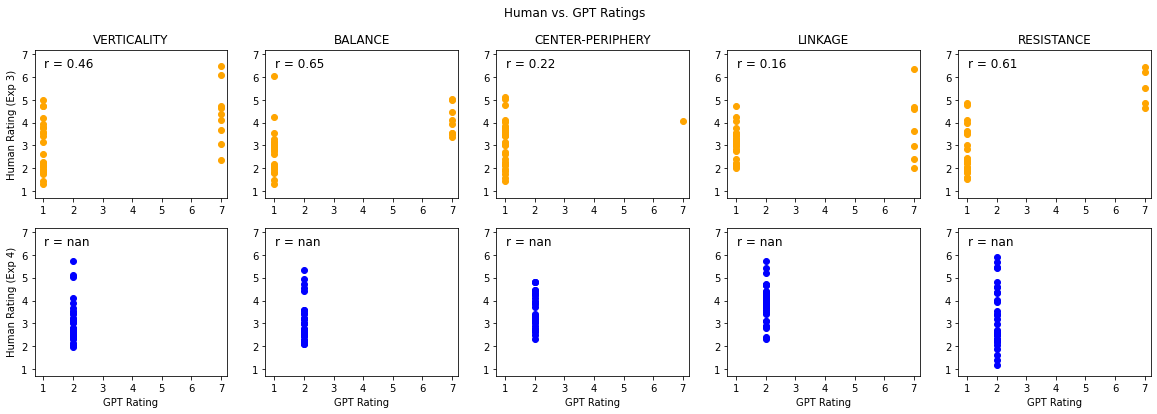

In [161]:
make_scatter_plots(full_history_results_exp3, full_history_results_exp4, "Human vs. GPT Ratings")

# Full Questionaire Experiments (single Image Schema)

In [39]:
model="gpt-3.5-turbo-0613"
history_results_exp3={}
history_results_exp4={}
for key in DEFINITIONS:
    print("\n", key)
    history_results_exp3[key] = []
    history_results_exp4[key] = []
    gpt_c3=gpt_with_nearly_full_instructions(model=model, image_schema=key, stimuli=stimuli_exp3) 
    time.sleep(20)
    gpt_c4=gpt_with_nearly_full_instructions(model=model, image_schema=key, stimuli=stimuli_exp4)
    time.sleep(20)
    # extract numbers from response
    c3=gpt_c3["choices"][0]["message"]["content"]
    c4=gpt_c4["choices"][0]["message"]["content"]
    print("\nExperiment 3")
    print(c3)
    print("\nExperiment 4")
    print(c4)
    c3=c3.split("\n")
    c4=c4.split("\n")
    c3=[i.split(":")[1].strip() for i in c3]
    c4=[i.split(":")[1].strip() for i in c4]
    history_results_exp3[key]=c3
    history_results_exp4[key]=c4

for IS in history_results_exp3:
    # turn list of strings (e.g. ["1","2"]) into ints (e.g. [1,2])
    history_results_exp3[IS] = [int(rating) for rating in history_results_exp3[IS]]
for IS in history_results_exp4:
    # turn list of strings (e.g. ["1","2"]) into ints (e.g. [1,2])
    history_results_exp4[IS] = [int(rating) for rating in history_results_exp4[IS]]


 VERTICALITY

Experiment 3
1: 6
2: 4
3: 6
4: 5
5: 6
6: 6
7: 6
8: 4
9: 3
10: 2
11: 6
12: 6
13: 2
14: 5
15: 6
16: 6
17: 6
18: 5
19: 6
20: 5
21: 5
22: 6
23: 6
24: 6
25: 5
26: 5
27: 6
28: 4
29: 6
30: 6
31: 4
32: 6

Experiment 4
1: 2
2: 1
3: 6
4: 2
5: 4
6: 5
7: 3
8: 2
9: 4
10: 2
11: 7
12: 7
13: 1
14: 4
15: 2
16: 7
17: 2
18: 3
19: 2
20: 4
21: 3
22: 2
23: 7
24: 7
25: 4
26: 5
27: 5
28: 2
29: 6
30: 1
31: 3
32: 6

 BALANCE

Experiment 3
1: 1
2: 2
3: 6
4: 5
5: 6
6: 6
7: 6
8: 4
9: 3
10: 2
11: 1
12: 3
13: 2
14: 4
15: 6
16: 5
17: 6
18: 5
19: 6
20: 4
21: 5
22: 5
23: 6
24: 4
25: 4
26: 4
27: 6
28: 3
29: 6
30: 6
31: 4
32: 5

Experiment 4
1: 1
2: 2
3: 6
4: 1
5: 4
6: 6
7: 5
8: 4
9: 6
10: 2
11: 1
12: 3
13: 1
14: 4
15: 5
16: 3
17: 2
18: 3
19: 4
20: 4
21: 3
22: 1
23: 3
24: 3
25: 4
26: 5
27: 6
28: 2
29: 5
30: 2
31: 3
32: 6

 CENTER-PERIPHERY

Experiment 3
1: 1
2: 4
3: 5
4: 6
5: 6
6: 6
7: 6
8: 4
9: 3
10: 4
11: 2
12: 3
13: 4
14: 4
15: 5
16: 6
17: 5
18: 5
19: 6
20: 4
21: 5
22: 6
23: 3
24: 4
25: 4
26: 5
27: 6
28

In [ ]:
# history_results_expX to pkl
with open('history_results_exp4.pkl', 'wb') as f:
    pickle.dump(history_results_exp4, f)

with open('history_results_exp3.pkl', 'wb') as f:
    pickle.dump(history_results_exp3, f)   

In [133]:
print_correlations(history_results_exp3, history_results_exp4)

VERTICALITY
Experiment 3: SpearmanrResult(correlation=0.39248203951590666, pvalue=0.02629062682584727)
Experiment 4: SpearmanrResult(correlation=0.18066380733387408, pvalue=0.3224178507761486)

BALANCE
Experiment 3: SpearmanrResult(correlation=0.13341795203218007, pvalue=0.46663645952245225)
Experiment 4: SpearmanrResult(correlation=0.22565818366289975, pvalue=0.21430256336588713)

CENTER-PERIPHERY
Experiment 3: SpearmanrResult(correlation=0.45838062223891046, pvalue=0.008328988276605017)
Experiment 4: SpearmanrResult(correlation=0.03487005828984612, pvalue=0.8497289613404104)

LINKAGE
Experiment 3: SpearmanrResult(correlation=0.640534792236373, pvalue=7.853556238578637e-05)
Experiment 4: SpearmanrResult(correlation=0.4047371197296721, pvalue=0.021575491456038046)

RESISTANCE
Experiment 3: SpearmanrResult(correlation=0.499589546870746, pvalue=0.0036003409174275905)
Experiment 4: SpearmanrResult(correlation=0.7112514570467381, pvalue=5.0445279741929784e-06)



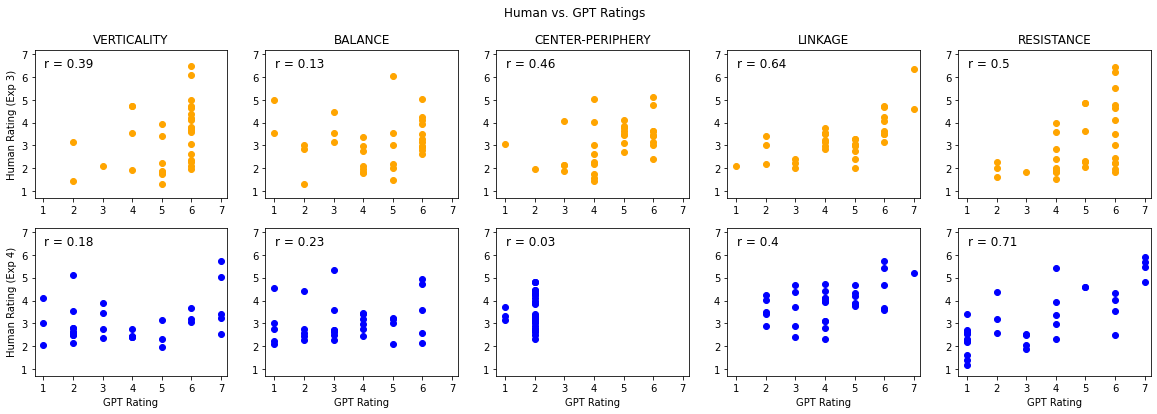

In [124]:
make_scatter_plots(history_results_exp3, history_results_exp4, "Human vs. GPT Ratings")

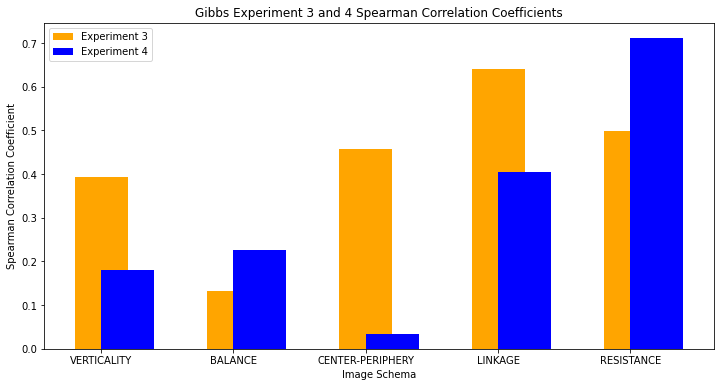

In [125]:
make_bar_plots(model_result_dict_3=history_results_exp3, model_result_dict_4=history_results_exp4, title="Gibbs Experiment 3 and 4 Spearman Correlation Coefficients")

# Single Prompts Experiments

In [162]:
model = "text-davinci-003"
completions_exp3 = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIPHERY": [], "LINKAGE": [], "RESISTANCE": []}

for i in range(len(stimuli_exp3)):
    for k in completions_exp3:
        completions_exp3[k].append(gpt_complete(prompts_exp3[k][i], model))
        time.sleep(21)

with open('completions_single_prompt_exp3.pkl', 'wb') as f:
    pickle.dump(completions_exp3, f)

In [58]:
completions_exp4 = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIPHERY": [], "LINKAGE": [], "RESISTANCE": []} 
assert len(completions_exp3) == len(completions_exp4)
for i in range(len(stimuli_exp4)):
    for k in completions_exp4:
        completions_exp4[k].append(gpt_complete(prompts_exp4[k][i], model))
        time.sleep(30)

with open('completions_single_prompt_exp4.pkl', 'wb') as f:
    pickle.dump(completions_exp4, f)

In [60]:
# extract only the numbers from the completions

completions_exp3_clean = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIPHERY": [], "LINKAGE": [], "RESISTANCE": []}
completions_exp4_clean = {"VERTICALITY": [], "BALANCE": [], "CENTER-PERIPHERY": [], "LINKAGE": [], "RESISTANCE": []}

for k in completions_exp3:
    for i in range(len(completions_exp3[k])):
        clean_item = completions_exp3[k][i]["choices"][0]["text"]
        clean_item = int(re.findall(r'\d+', clean_item)[0])
        completions_exp3_clean[k].append(clean_item)

for k in completions_exp4:
    for i in range(len(completions_exp4[k])):
        clean_item = completions_exp4[k][i]["choices"][0]["text"]
        clean_item = int(re.findall(r'\d+', clean_item)[0])
        completions_exp4_clean[k].append(clean_item)

### Correlation Analysis

In [85]:
print("Spearman correlations for experiment 3")
for k in completions_exp3_clean:
    print(k, stats.spearmanr(completions_exp3_clean[k], exp_3_df[k]))

print("Spearman correlations for experiment 4")
for k in completions_exp4_clean:
    print(k, stats.spearmanr(completions_exp4_clean[k], exp_4_df[k]))
    

Spearman correlations for experiment 3
Spearman correlations for experiment 4
VERTICALITY SpearmanrResult(correlation=0.6833876221034471, pvalue=1.627063547884175e-05)
BALANCE SpearmanrResult(correlation=0.6771840725179004, pvalue=2.0761491611577507e-05)
CENTER-PERIPHERY SpearmanrResult(correlation=0.6901380535614554, pvalue=1.23965800957632e-05)
LINKAGE SpearmanrResult(correlation=0.5197179828067287, pvalue=0.0022993844979337305)
RESISTANCE SpearmanrResult(correlation=0.7058717439215124, pvalue=6.389977181110315e-06)


In [21]:
# TODO Old remove
r_V = stats.spearmanr(completion_numbers_V, exp_3_df["V"].values)
print("Verticality Spearman R: ", r_V)

r_B = stats.spearmanr(completion_numbers_B, exp_3_df["B"].values)
print("Balance Spearman R: ", r_B)

r_C = stats.spearmanr(completion_numbers_C, exp_3_df["CP"].values)
print("Center-Peripher Spearman R: ", r_C)

r_R = stats.spearmanr(completion_numbers_R, exp_3_df["R"].values)
print("Resistance Spearman R: ", r_R)

r_L = stats.spearmanr(completion_numbers_L, exp_3_df["L"].values)
print("Linkage Spearman R: ", r_L)

Verticality Spearman R:  SpearmanrResult(correlation=0.5319115370624121, pvalue=0.001728905163310417)
Blockage Spearman R:  SpearmanrResult(correlation=0.3889504346025759, pvalue=0.02779617841811564)
Center-Peripher Spearman R:  SpearmanrResult(correlation=0.7397528813626304, pvalue=1.3126737552856912e-06)
Resistance Spearman R:  SpearmanrResult(correlation=0.6820014752671762, pvalue=1.71900059033538e-05)
Linkage Spearman R:  SpearmanrResult(correlation=0.5431252313598959, pvalue=0.0013174767080267854)


In [28]:
# TODO: change to work with new data format
# Mean Absolute Error
print("MAE Verticality:", mean_absolute_error(completion_numbers_V, exp_3_df['V']))
print("MAE Balance:", mean_absolute_error(completion_numbers_B, exp_3_df['B']))
print("MAE CP:", mean_absolute_error(completion_numbers_C, exp_3_df['CP']))
print("MAE Resistance:", mean_absolute_error(completion_numbers_R, exp_3_df['R']))
print("MAE Linkage:", mean_absolute_error(completion_numbers_L, exp_3_df['L']))






MSE Verticality: 1.8465624999999999
MSE Balance: 1.448125
MSE CP: 2.0453125
MSE Resistance: 1.2834375
MSE Linkage: 2.364375


In [ ]:
# make new csv 

## Linear Discriminant Analysis

We repeate the analysis from the paper but this time with the numbers generated from GPT instead of humans

Problem: The paper scores can not be reproduced!

In [146]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 

from sklearn.metrics import accuracy_score

In [105]:
cluster_1=["one-night stand", "let the mixture stand", "a standing ovation", "on the witness stand", "the police told them to stand back", "stand at attention", "let the issue stand", "stand out in several sports", "the boss always stands over me", "to stand the test of time", "don't stand for such treatment"]
cluster_2=["to stand in someone else's shoes", "the clock stands on the mantle", "he stands committed", "we stand on 30 years of experience", "united we stand", "stand on shaky ground", "to stand firm", "stand in awe", "to stand to profit"]
cluster_3=["stand by your man", "to stand accused", "the house stands in the clearing", "he stands six-foot nine", "the barometer stands at 30 inches", "to stand against great odds", "they did nothing but stand around", "the engine can't stand the constant wear", "the part stands for the whole", "it stands to reason", "get stood up for a date", "as the matter now stands"]

In [149]:
# LDA with GPT data 
y = []
for s in stimuli_exp3:
    if s in cluster_1:
        y.append(0)
    elif s in cluster_2:
        y.append(1)
    elif s in cluster_3:
        y.append(2)
    else:
        print('error regarding:', s)

x_exp3 = []
x_exp4 = []
for i in range(len(stimuli_exp4)):
    schema_profile = []
    for k in completions_exp4_clean:
        schema_profile.append(completions_exp4_clean[k][i])
    x_exp4.append(schema_profile)


clf = QuadraticDiscriminantAnalysis()
clf.fit(x_exp4, y)
y_pred4 = clf.predict(x_exp4)
print('accuracy exp4:', accuracy_score(y_true=y, y_pred=y_pred4))





accuracy exp4: 0.84375


In [147]:
# LDA with original participant data
x_original3 = []
x_original4 = []
for s in stimuli_exp3:
    schema_profile = exp_3_df[exp_3_df['Stimulus'] == s].iloc[:, 1:6].values[0].tolist()
    x_original3.append(schema_profile)
for s in stimuli_exp4:
    schema_profile = exp_4_df[exp_4_df['Stimulus'] == s].iloc[:, 1:6].values[0].tolist()
    x_original4.append(schema_profile)

# LDA with participant data with IS
clf = QuadraticDiscriminantAnalysis()
clf.fit(x_original3, y)
y_pred3 = clf.predict(x_original3)
print('accuracy original exp3:', accuracy_score(y_true=y, y_pred=y_pred3))

clf.fit(x_original4, y)
y_pred4 = clf.predict(x_original4)
print('accuracy original exp4:', accuracy_score(y_true=y, y_pred=y_pred4))



accuracy original exp3: 0.6875
accuracy original exp4: 0.71875


In [138]:
for i in range(len(x_original4)):
    print(stimuli_exp4[i])
    print(x_original4[i])
    print("")

be at attention
[3.4, 5.1, 4.53, 3.3, 3.5]

be distinguished in several sports
[2.2, 3.0, 4.43, 3.73, 4.67]

to hold firm
[5.47, 3.67, 4.73, 3.3, 4.0]

don't allow such treatment
[5.9, 2.6, 3.03, 3.13, 4.03]

to pass the test of time
[4.03, 2.4, 3.4, 2.73, 4.2]

united we are strong
[4.33, 3.13, 4.93, 4.27, 5.73]

we are backed up by 30 years experience
[2.5, 2.73, 3.0, 3.13, 5.2]

let the issue remain as is
[3.37, 2.47, 2.97, 2.47, 2.87]

leave the mixture undisturbed
[2.97, 2.43, 3.6, 2.6, 2.33]

have a dale with someone who didn 't show up
[3.93, 2.8, 2.27, 3.87, 4.23]

he measures six-foot nine
[1.6, 5.73, 2.73, 2.3, 2.4]

the clock is on the mantle
[1.17, 3.23, 3.6, 2.77, 3.1]

one-night fling
[2.7, 2.03, 2.1, 3.13, 3.43]

to be in the position to make a profit
[2.03, 2.73, 3.2, 4.27, 3.9]

to be in someone else's shoes
[2.57, 2.63, 2.1, 4.13, 4.67]

on the witness platform
[3.17, 3.4, 2.6, 4.83, 4.1]

be in aw
[2.23, 2.47, 2.57, 3.43, 4.37]

the police told them to get back
[5.43

In [139]:
for i in range(len(x_original3)):
    print(stimuli_exp3[i])
    print(x_original3[i])
    print("")

stand at attention
[4.0, 6.08, 5.0, 3.08, 2.08]

stand out in several sports
[2.0, 3.54, 2.83, 5.04, 3.42]

to stand firm
[6.21, 4.13, 5.04, 3.75, 2.83]

don't stand for such treatment
[5.54, 2.21, 3.04, 3.13, 3.08]

to stand the test of time
[4.88, 2.38, 3.92, 3.0, 4.08]

united we stand
[4.79, 4.21, 4.25, 4.78, 6.33]

we stand on 30 years of experience
[2.46, 2.63, 2.92, 3.43, 4.58]

let the issue stand
[2.83, 1.92, 2.08, 3.04, 2.96]

let the mixture stand
[1.54, 2.08, 3.17, 1.88, 2.0]

get stood up for a date
[1.83, 3.17, 3.04, 2.29, 2.17]

he stands six-foot nine
[2.29, 6.5, 3.54, 1.96, 2.0]

the clock stands on the mantle
[2.0, 4.38, 4.46, 2.13, 2.42]

one-night stand
[1.63, 1.46, 1.29, 2.17, 3.04]

to stand to profit
[2.04, 1.75, 1.79, 1.74, 3.54]

to stand in someone else's shoes
[2.25, 3.58, 2.96, 4.13, 4.7]

on the witness stand
[1.83, 2.08, 1.5, 3.63, 2.96]

stand in awe
[2.33, 3.75, 3.29, 3.65, 3.5]

the police told them to stand back
[3.63, 3.42, 2.17, 3.46, 2.74]

stand by